In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")

In [2]:
df = pd.read_csv("data/eda_2.csv", low_memory=False)

In [3]:
df.dtypes

SalesID                           int64
SalePrice                       float64
MachineID                         int64
ModelID                           int64
datasource                        int64
                                 ...   
Backhoe_Mounting_is_missing        bool
Blade_Type_is_missing              bool
Travel_Controls_is_missing         bool
Differential_Type_is_missing       bool
Steering_Controls_is_missing       bool
Length: 103, dtype: object

## Split our data into train and test

The data for this competition is split into three parts:

- Train.csv is the training set, which contains data through **the end of 2011**.
- Valid.csv is the validation set, which contains data from **January 1, 2012 - April 30, 2012** You make predictions on this set throughout the majority of the competition.
- Test.csv is the test set. It contains data from **May 1, 2012 - November 2012**.

In [5]:
df.saleYear.tail()

412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, dtype: int64

In [6]:
df.saleMonth.tail()

412693    4
412694    4
412695    4
412696    4
412697    4
Name: saleMonth, dtype: int64

#### observation
Though train and validation file is given separately, I wanted to create the validation set on my own. So I imported `TrainAndValid.csv` file in the first place instead of importing `Train.csv` file

In [7]:
df.saleYear.value_counts().sort_index()

1989     4806
1990     4529
1991     5109
1992     5519
1993     6303
1994     7929
1995     8530
1996     8829
1997     9785
1998    13046
1999    12793
2000    17415
2001    17594
2002    17246
2003    15254
2004    19879
2005    20463
2006    21685
2007    32208
2008    39767
2009    43849
2010    33390
2011    35197
2012    11573
Name: saleYear, dtype: int64

In [8]:
# split data into train and validation
df_train = df[df["saleYear"] < 2012]
df_valid = df[df["saleYear"] == 2012]
len(df_valid)

11573

In [11]:
np.unique(df_train.saleYear)

array([1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011], dtype=int64)

In [12]:
# split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_valid, y_valid = df_valid.drop("SalePrice", axis=1), df_valid["SalePrice"]

In [13]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [59]:
X_train.to_csv("data/x_train.csv", index=False)

## Evaluation metric

The evaluation metric for this competition is the **RMSLE (root mean squared log error)** between the actual and predicted auction prices.

In [16]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

In [15]:
def rmsle(y_test, y_pred):
    """
    Calculate root measn squared log error between test data and predicted data
    """
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

In [36]:
def show_score(model):
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_pred),
              "Validation MAE": mean_absolute_error(y_valid, valid_pred),
              "Training RMSLE": rmsle(y_train, train_pred),
              "Validation RMSLE": rmsle(y_valid, valid_pred),
              "Training R^2": r2_score(y_train, train_pred),
              "Validation R^2": r2_score(y_valid, valid_pred)}
    return scores

#### observation

It took nearly 21 minutes in the previus notebook to train the model. So before doing so, tune the hyperparameters on subset of the training data to reduce the time of training.

## Hyperparameter tuning

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
%%time

model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

Wall time: 19min 16s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [20]:
dir(model)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'bootstrap',
 'ccp_alpha',
 'class_weight',
 'criterion',
 'decision_path',
 'estimator_params',
 'feature_importa

**max_samples :** int or float, default=None

If bootstrap is True, the number of samples to draw from X to train each base estimator.

- If None (default), then draw `X.shape[0]` samples.
- If int, then draw `max_samples` samples.
- If float, then draw `max_samples * X.shape[0]` samples. Thus, `max_samples` should be in the interval `(0, 1)`.


In [28]:
X_train.shape[0]

401125

In [29]:
model.n_estimators

100

##### observation
if `max_samples=None`, every 100 estimators will calculate for large number of samples: `X_train.shape[0] = 401125`

In [30]:
X_train.shape[0] * model.n_estimators

40112500

### Reducing data

In [33]:
%%time

model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)
model.fit(X_train, y_train)

Wall time: 4min 34s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

Still took 4 minutes+, so my pc is very slow 😥

In [37]:
# showing scores
show_score(model)

{'Training MAE': 6407.885300392647,
 'Validation MAE': 8633.326159163571,
 'Training RMSLE': 0.3039361354447437,
 'Validation RMSLE': 0.3789932056768934,
 'Training R^2': 0.8179641412786905,
 'Validation R^2': 0.7681849235754674}

So my $ RMSLE \approx 0.3789 $

The best score in the kaggle leaderboard $ \approx 0.229 $

### Hyperparameter tuning with `RandomizedSearchCV` because `GridSearchCV` is slow

In [38]:
from sklearn.model_selection import RandomizedSearchCV

In [39]:
%%time

estimator = RandomForestRegressor(n_jobs=-1, random_state=42)
param_distribution = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 10, 2),
    "min_samples_leaf": np.arange(2, 10, 2),
    "max_features": ["auto", "sqrt", "log2", 0.5, 1],
    "max_samples": [10000]
}

rs_model = RandomizedSearchCV(estimator,
                              param_distribution,
                              cv=5,
                              n_iter=2,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.4min finished


Wall time: 2min 32s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         0.5, 1],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([2, 4, 6, 8]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [40]:
pd.DataFrame(rs_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_samples,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,19.979338,20.514143,1.269279,0.072749,60,8,4,10000,log2,10,"{'n_estimators': 60, 'min_samples_split': 8, '...",0.311564,0.473211,0.480899,0.462814,0.459430,0.437584,0.063467,2
1,6.783725,0.084919,0.891496,0.040498,10,2,2,10000,auto,5,"{'n_estimators': 10, 'min_samples_split': 2, '...",0.290401,0.523888,0.570024,0.512298,0.490148,0.477352,0.097045,1


#### increasing `n_iter`

In [41]:
%%time

estimator = RandomForestRegressor(n_jobs=-1, random_state=42)
param_distribution = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 10, 2),
    "min_samples_leaf": np.arange(2, 10, 2),
    "max_features": ["auto", "sqrt", 0.5, 1],
    "max_samples": [10000]
}

rs_model = RandomizedSearchCV(estimator,
                              param_distribution,
                              cv=5,
                              n_iter=10,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  9.5min finished


Wall time: 9min 49s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': ['auto', 'sqrt', 0.5,
                                                         1],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([2, 4, 6, 8]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [42]:
pd.DataFrame(rs_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_samples,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.374594,1.917335,1.573104,0.065684,80,8,2,10000,0.5,None,"{'n_estimators': 80, 'min_samples_split': 8, '...",0.515769,0.731894,0.757783,0.734450,0.704748,0.688929,0.088197,1
1,8.863159,0.212388,1.342632,0.038958,60,6,2,10000,1,None,"{'n_estimators': 60, 'min_samples_split': 6, '...",0.286343,0.420228,0.428399,0.395145,0.374361,0.380895,0.050970,6
2,12.006926,0.267660,1.006625,0.047153,60,4,4,10000,0.5,5,"{'n_estimators': 60, 'min_samples_split': 4, '...",0.269426,0.526519,0.537665,0.499810,0.491165,0.464917,0.099207,5
3,6.249862,0.348420,0.977649,0.020388,30,2,8,10000,1,10,"{'n_estimators': 30, 'min_samples_split': 2, '...",0.212552,0.251613,0.265759,0.257085,0.261426,0.249687,0.019150,10
4,11.651922,0.268023,0.965445,0.014091,60,4,8,10000,0.5,5,"{'n_estimators': 60, 'min_samples_split': 4, '...",0.274773,0.524644,0.536003,0.501122,0.494050,0.466119,0.096879,4
5,5.449695,0.368582,0.865311,0.012683,10,8,6,10000,auto,3,"{'n_estimators': 10, 'min_samples_split': 8, '...",0.124801,0.405102,0.411109,0.388797,0.389647,0.343891,0.109887,8
6,7.272641,0.083029,1.095175,0.033581,50,8,2,10000,1,10,"{'n_estimators': 50, 'min_samples_split': 8, '...",0.209213,0.283808,0.289753,0.284185,0.305709,0.274533,0.033614,9
7,6.048348,0.319712,0.873498,0.040030,20,2,6,10000,sqrt,5,"{'n_estimators': 20, 'min_samples_split': 2, '...",0.262037,0.390258,0.414022,0.405157,0.418873,0.378070,0.058827,7
8,12.833652,0.249005,1.627463,0.049542,90,6,6,10000,sqrt,None,"{'n_estimators': 90, 'min_samples_split': 6, '...",0.399580,0.600278,0.609187,0.581833,0.552428,0.548661,0.077029,2
9,8.780026,0.165594,1.150742,0.052328,50,4,6,10000,sqrt,10,"{'n_estimators': 50, 'min_samples_split': 4, '...",0.361279,0.533836,0.544932,0.528723,0.513123,0.496379,0.068321,3


In [43]:
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [44]:
rs_model.best_score_

0.688928739326872

In [45]:
show_score(rs_model)

{'Training MAE': 6842.109312633169,
 'Validation MAE': 9131.856132887988,
 'Training RMSLE': 0.31817531332062776,
 'Validation RMSLE': 0.38916720740428873,
 'Training R^2': 0.7929329947948409,
 'Validation R^2': 0.7374045663465907}

### for `n_estimator=20`

#### observation

- we got worst score when `max_features = 1`
- we got worst score when `max_depth = 5, 10`

In [46]:
%%time

estimator = RandomForestRegressor(n_jobs=-1, random_state=42)
param_distribution = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(2, 20, 2),
    "max_features": ["auto", "sqrt", 0.5],
    "max_samples": [10000]
}

rs_model = RandomizedSearchCV(estimator,
                              param_distribution,
                              cv=5,
                              n_iter=20,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 22.5min finished


Wall time: 22min 42s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 3],
                                        'max_features': ['auto', 'sqrt', 0.5],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [49]:
pd.DataFrame(rs_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_samples,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,17.285297,2.368256,1.165731,0.098347,30,6,2,10000,auto,None,"{'n_estimators': 30, 'min_samples_split': 6, '...",0.524368,0.737552,0.776094,0.736118,0.721435,0.699113,0.089227,1
1,12.180031,0.413569,1.123761,0.075543,40,2,18,10000,0.5,None,"{'n_estimators': 40, 'min_samples_split': 2, '...",0.457658,0.679019,0.704250,0.678314,0.638968,0.631642,0.089464,8
2,26.513828,0.424530,1.404603,0.189693,70,18,12,10000,auto,None,"{'n_estimators': 70, 'min_samples_split': 18, ...",0.471626,0.719144,0.745968,0.706714,0.686171,0.665924,0.099061,5
3,11.552806,0.264254,1.430375,0.029051,80,16,18,10000,sqrt,None,"{'n_estimators': 80, 'min_samples_split': 16, ...",0.361238,0.555486,0.560470,0.538147,0.517754,0.506619,0.074218,12
4,6.944248,0.182081,1.040999,0.064741,30,10,16,10000,sqrt,None,"{'n_estimators': 30, 'min_samples_split': 10, ...",0.357760,0.568060,0.577692,0.541104,0.524601,0.513843,0.080296,11
5,23.984293,0.571128,1.275668,0.058535,60,4,6,10000,auto,None,"{'n_estimators': 60, 'min_samples_split': 4, '...",0.499055,0.734152,0.761697,0.729455,0.709701,0.686812,0.095335,2
6,22.047175,1.029570,1.222905,0.068283,60,4,10,10000,auto,None,"{'n_estimators': 60, 'min_samples_split': 4, '...",0.478225,0.725091,0.750096,0.713690,0.694372,0.672295,0.098696,3
7,6.849022,0.229364,0.832916,0.013172,10,12,18,10000,auto,None,"{'n_estimators': 10, 'min_samples_split': 12, ...",0.454224,0.686207,0.733197,0.685213,0.664287,0.644625,0.097837,7
8,4.891230,0.277246,0.834525,0.037068,10,10,14,10000,0.5,3,"{'n_estimators': 10, 'min_samples_split': 10, ...",0.153362,0.379253,0.399069,0.384259,0.377610,0.338711,0.092983,19
9,11.798648,0.290412,0.887484,0.091335,60,16,2,10000,auto,3,"{'n_estimators': 60, 'min_samples_split': 16, ...",0.134504,0.414951,0.414814,0.366691,0.374388,0.341070,0.105198,17


In [50]:
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [52]:
rs_model.best_score_

0.6991134977057399

In [53]:
show_score(rs_model)

{'Training MAE': 6526.112242636631,
 'Validation MAE': 8710.976912963808,
 'Training RMSLE': 0.3072770683868122,
 'Validation RMSLE': 0.3784449565724856,
 'Training R^2': 0.8086844240225517,
 'Validation R^2': 0.757956061159849}

## Fit the whole training data with the best params

In [56]:
%%time

ideal_model = RandomForestRegressor(n_estimators=30,
                                    min_samples_split=6,
                                    min_samples_leaf=2,
                                    max_samples=None,
                                    max_features="auto",
                                    n_jobs=-1,
                                    random_state=42)

ideal_model.fit(X_train, y_train)

Wall time: 6min 20s


RandomForestRegressor(min_samples_leaf=2, min_samples_split=6, n_estimators=30,
                      n_jobs=-1, random_state=42)

In [57]:
show_score(ideal_model)

{'Training MAE': 2474.9972878188632,
 'Validation MAE': 7082.182325980664,
 'Training RMSLE': 0.13101320546172862,
 'Validation RMSLE': 0.31010564487391495,
 'Training R^2': 0.9675216250908677,
 'Validation R^2': 0.8356591576071729}

### Save the model

In [66]:
import joblib

In [67]:
joblib.dump(ideal_model, "model/ideal_model_1")
# to load the model
# model = joblib.load(model_file_path)

['model/ideal_model_1']

## Make predictions on test data

In [58]:
df_test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### import modiefied test data

In [60]:
df_test = pd.read_csv("data/eda_test.csv", low_memory=False)
len(df_test.columns)

102

In [61]:
# prediction
test_preds = ideal_model.predict(df_test)

In [62]:
len(test_preds)

12457

### Format predictions for `kaggle`

https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [63]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds.head()

,SalesID,SalesPrice
0,4317459,29843.333333
1,4249784,28583.540164
2,4392603,23768.121693
3,4274831,47707.797619
4,4362801,55054.570106


### Export prediction data

In [68]:
df_preds.to_csv("data/test_predictions.csv", index=False)

### Feature importance

In [69]:
ideal_model.feature_importances_

array([5.49549516e-02, 2.55403836e-02, 2.32321050e-01, 6.91827709e-04,
       5.25174167e-03, 2.46058500e-01, 5.71206612e-03, 2.88908852e-04,
       2.76617305e-04, 2.60392623e-04, 2.87283981e-04, 2.70578237e-04,
       2.91237996e-04, 2.71498894e-04, 2.56167515e-04, 2.71580270e-04,
       2.78419739e-04, 2.68655386e-04, 2.91988770e-04, 2.61224605e-04,
       2.80112308e-04, 2.67563343e-04, 2.69140194e-04, 2.61387559e-04,
       2.69667004e-04, 2.70946081e-04, 2.52932583e-04, 2.88108350e-04,
       2.81188844e-04, 2.61604644e-04, 2.69515006e-04, 2.64581879e-04,
       2.77647543e-04, 2.63924793e-04, 2.73638883e-04, 2.83980820e-04,
       2.93766440e-04, 2.79842073e-04, 2.57809803e-04, 2.75184955e-04,
       2.63191970e-04, 2.88154060e-04, 2.61593068e-04, 2.73042358e-04,
       2.77658381e-04, 2.82490546e-04, 2.64963513e-04, 2.71684072e-04,
       2.63679666e-04, 2.53111935e-04, 2.71168178e-04, 8.07283897e-02,
       3.42851275e-03, 1.07561431e-02, 5.14694296e-03, 1.60747709e-02,
      

In [70]:
len(ideal_model.feature_importances_)

102

In [71]:
ideal_model.feature_importances_.max()

0.24605850009023178

In [76]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns, "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set(xlabel="Feature importance", ylabel="features")
    ax.invert_yaxis()

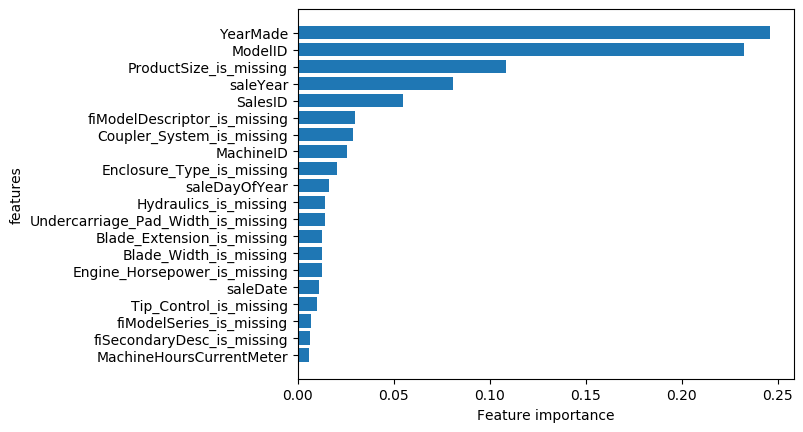

In [77]:
plot_features(X_train.columns, ideal_model.feature_importances_);